In [1]:
import graph_tool.all as gt
import numpy as np
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

変数を設定

・S：未感染者

・I：感染者

・R：免疫者

In [2]:
S = 0
I = 1
R = -1

確率を設定

・しきい値（S → I）：T

・回復率（I → R）：r

In [3]:
T = 0.3
r = 0.1

LTモデルの関数定義

In [4]:
def LT():
    # 全ノードをランダムに並べ替える
    vs = list(G.vertices())
    rnd.shuffle(vs)
    # 並べ替えたノードリストを走査し状態更新を行う
    for v in vs:
        if state[v] == S:
            # S状態のノードの隣接ノードを取得
            ns = list(v.out_neighbors())
            # 隣接ノードの中でI状態のノードの数をカウント
            num_infected_neighbors = sum(1 for n in ns if state[n] == I)
            # 隣接ノードが存在する場合、I状態のノードの割合を計算
            if len(ns) > 0:
                infected_ratio = num_infected_neighbors / len(ns)
                # 割合がT以上なら、状態をIに変更
                if infected_ratio >= T:
                    state[v] = I
        elif state[v] == I:
            # 状態がIの場合、確率rでR状態に変更
            if rnd.random() < r:
                state[v] = R
    return

例：WSモデルに対するLTを行ってみる

WSモデル

In [5]:
def ws_graph(n, k, p):
    #基本となる円形格子を生成
    base_g = gt.circular_graph(n, k)
    
    #p = 0、リンクの張替えをしない場合は、そのまま円形格子を返却する
    if p == 0:
        return base_g
    
    #リンクの張替えがあり得る場合、空の無向グラフ(directed = False)を生成し、n個のノード数を付け加える
    g = gt.Graph(directed = False)
    g.add_vertex(n)
    #張替え前のbase_gのすべてのリンクを走査し、生成乱数がpより少なければ、リンクの張替えを行う
    #ただし、複数リンク・自己ループとならないようにする
    for edg in base_g.edges():
        st_vtx = edg.source()
        tg_vtx = edg.target()
        if rnd.random() < p:
            #新しいリンク先の候補を生成
            nw_tg_idx = rnd.choice(n)
            nw_tg_vtx = base_g.vertex(nw_tg_idx)
            while ((nw_tg_vtx in st_vtx.all_neighbors())
            or nw_tg_vtx == st_vtx):
                #もし、新しいリンク先によって複数リンク・自己ループになる場合、別のリンク先を新たに探す
                nw_tg_idx = rnd.choice(n)
                nw_tg_vtx = base_g.vertex(nw_tg_idx)
            if g.edge(st_vtx, nw_tg_vtx) == None:
                #以前のリンク張替えによって、張ろうとするリンクがすでにある場合をのぞき、リンクの張替えを行う
                g.add_edge(st_vtx, nw_tg_vtx)
        else:
            if g.edge(st_vtx, tg_vtx) == None:
                g.add_edge(st_vtx, tg_vtx)
    return g

In [6]:
# 4種類のWSモデルをランダムに各10個生成する
p_values = [0.001, 0.01, 0.1, 1.0]
num_samples = 10

ws_graphs = [[] for _ in p_values]

for p_idx, p in enumerate(p_values):
    p = p_values[p_idx]
    for _ in range(num_samples):
        ws_g = ws_graph(1000, 2, p)
        ws_graphs[p_idx].append(ws_g)

シミュレーションにおける変数設定

In [7]:
# 何回感染シミュレーションを繰り返すのか？
max_itr = 100

# 1つのWSモデルに対して、一連の感染シミュレーションの平均を何回でとるのか？
num_iterations = 10

# 初期感染者の数と、取得する値の間隔を指定する
v_change_range = range(10, 201, 10)

In [ ]:
            # 状態初期化、ランダムに初期感染者を選ぶ場合
            for v in G.vertices():
                state[v] = S
            nodes = list(G.vertices())
            random.shuffle(nodes)
            for v in nodes[:v_change]:
                state[v] = I
                
            # 状態初期化、ノードの次数の高い順に初期感染者を選ぶ場合
            for v in G.vertices():
                state[v] = S
            nodes = list(G.vertices())
            nodes_degrees = [(v, G.vertex(v).in_degree() + G.vertex(v).out_degree()) for v in nodes]
            nodes_sorted = [v for v, _ in sorted(nodes_degrees, key=lambda x: x[1], reverse=True)]
            for v in nodes_sorted[:v_change]:
                state[v] = I
                
            # 状態初期化、ノードの次数の低い順に初期感染者を選ぶ場合
            for v in G.vertices():
                state[v] = S
            nodes = list(G.vertices())
            nodes_degrees = [(v, G.vertex(v).in_degree() + G.vertex(v).out_degree()) for v in nodes]
            nodes_sorted = [v for v, _ in sorted(nodes_degrees, key=lambda x: x[1])]
            for v in nodes_sorted[:v_change]:
                state[v] = I

In [13]:
Result_R = []
Result_time = []

for v_change in v_change_range:
    print(f"v_change = {v_change}")
    result_list = []
    time_list = []
    
    for _ in range(num_samples):
        G = ws_graphs[3][_]
        S_avg = []
        X_avg = []
        R_avg = []
        result = []
        time = []
        
        # G0からG99までのコピーを作成する
        for i in range(num_iterations):
            locals()[f'G{i}'] = G.copy()
        
        for j in tqdm(range(num_iterations)):
            G = locals()[f'G{j}']
            # 状態初期化
            state = G.new_vertex_property("int")
            # 状態初期化、ノードの次数の低い順に初期感染者を選ぶ場合
            for v in G.vertices():
                state[v] = S
            nodes = list(G.vertices())
            nodes_degrees = [(v, G.vertex(v).in_degree() + G.vertex(v).out_degree()) for v in nodes]
            nodes_sorted = [v for v, _ in sorted(nodes_degrees, key=lambda x: x[1])]
            for v in nodes_sorted[:v_change]:
                state[v] = I
                    
            R_max = None
            R_stop = None
            suscept_st = []
            infect_st = []
            recov_st = []
            
            suscept_st.append(list(state.a).count(S))
            infect_st.append(list(state.a).count(I))
            recov_st.append(list(state.a).count(R))
            # シミュレーションの実行
            for updt in range(max_itr):
                LT(G)
                suscept_st.append(list(state.a).count(S))
                infect_st.append(list(state.a).count(I))
                recov_st.append(list(state.a).count(R))
                if 0 in infect_st:
                    i = infect_st.index(0)
                    R_max = recov_st[i]
                    R_stop = i
                    result.append((R_max))
                    time.append((R_stop))
                    break
                    
        result_list.append(np.mean(result, axis=0))
        time_list.append(np.mean(time, axis=0))
                
    RM = np.mean(result, axis=0)
    RS = np.mean(time, axis=0)
    Result_R.append(RM)
    Result_time.append(RS)

v_change = 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]


v_change = 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


v_change = 30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


v_change = 40


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.33it/s]


v_change = 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.24it/s]


v_change = 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


v_change = 70


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.35it/s]


v_change = 80


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


v_change = 90


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.00it/s]


v_change = 100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.54it/s]


v_change = 110


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.60it/s]


v_change = 120


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.55it/s]


v_change = 130


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.70it/s]


v_change = 140


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.64it/s]


v_change = 150


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.84it/s]


v_change = 160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.98it/s]


v_change = 170


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.05it/s]


v_change = 180


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.96it/s]


v_change = 190


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.03it/s]


v_change = 200


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.02it/s]


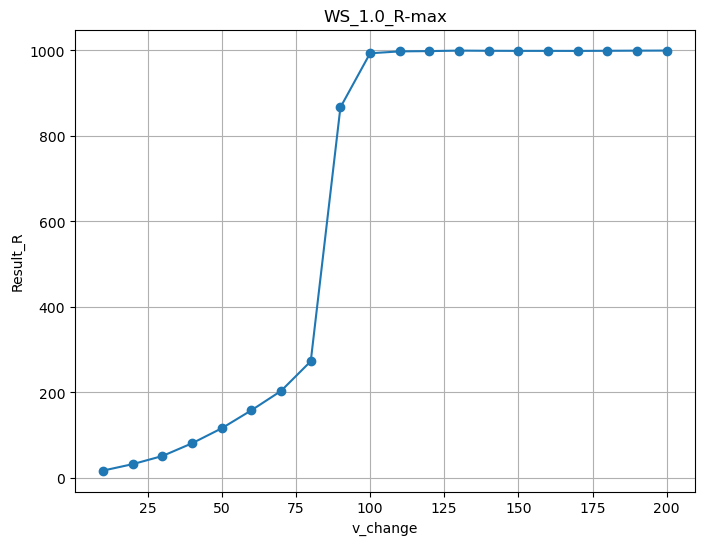

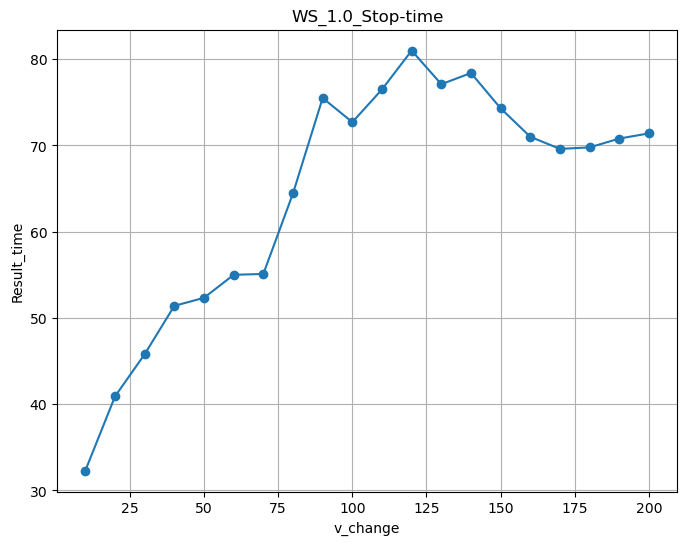

In [14]:
# Plotting Result_R
plt.figure(figsize=(8, 6))
plt.plot(v_change_range, Result_R, marker='o')
plt.xlabel('v_change')
plt.ylabel('Result_R')
plt.title('WS_1.0_R-max')
plt.grid(True)
plt.show()

# Plotting Result_time
plt.figure(figsize=(8, 6))
plt.plot(v_change_range, Result_time, marker='o')
plt.xlabel('v_change')
plt.ylabel('Result_time')
plt.title('WS_1.0_Stop-time')
plt.grid(True)
plt.show()